### Implementing MPC with perfect forecast in CityLearn

Import packages

In [1]:
# System operations
import os
import time
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet

# helper functions
from kpi_utils import get_kpis, plot_building_kpis, plot_district_kpis
from kpi_utils import plot_building_load_profiles, plot_district_load_profiles, plot_battery_soc_profiles, plot_simulation_summary
from env_utils import set_n_buildings_2022
from mpc_utils import mpc_district_optimization_2022

# packages for MPC
import cvxpy as cp
import joblib

Load data from CityLearn 2021 Challenge. 

In this challenge, the agents must control the energy stored by a micro-grid of 9 buildings in real-time for a period of 4 simulated years, on an hourly time-scale. Each building has 3 action-variables (domestic hot water storage, chilled water storage, and electrical storage), except for buildings 3 and 4 that do not have domestic hot water storage.

In [2]:
data_dir = '/home/jt9744/projects/thesis/CityLearn_thesis/data/datasets'
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
ds = DataSet()
schema = ds.get_schema(DATASET_NAME)

Data Preprocessing:
1. Use 2, 4, or 8 buildings to measure scalability (consider using 12 and 15 if there's enough time)
2. Use centralized control

These can be modified directly in the schema. The buildings will be pseudo-randomly selected with a seed for reproducibility. 

In [3]:
n_buildings = 2 # 2, 4, or 8 
schema, buildings = set_n_buildings_2022(schema, n_buildings)
print('Number of buildings:', n_buildings)
print('Selected buildings:', buildings)

# use centralized control
schema['central_agent'] = True

# test window
schema['simulation_end_time_step'] = 7*24 # one time step = one hour

Number of buildings: 2
Selected buildings: ['Building_8', 'Building_10']


Initialize a CityLearn Environment

In [4]:
env = CityLearnEnv(schema)

# check initialization
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})

Current time step: 0
environment number of time steps: 169
environment uses central agent: True
Number of buildings: 2
Electrical storage capacity: {'Building_8': 6.4, 'Building_10': 6.4}
Electrical storage nominal power: {'Building_8': 5.0, 'Building_10': 5.0}
Electrical storage efficiency: {'Building_8': 0.9, 'Building_10': 0.9}


Given a set of GEBs, the controllers aim to minimize the electricity cost, average peak demand, and carbon intensity of electricity consumed by the buildings. The evalu
tion will be based on these metrics while also including computational costs suchas 
 training time, inference time, RAM usage, and scalability across different numbe off
 builgs.

Three built-in key performance indicators can be used: cost, carbon emissions, and average daily peak. Average daily peak is a district-level KPI that is calculated using the aggregated district-level hourly net electricity consumption (kWh), $E_h^{\textrm{district}}$. Cost and carbon emissions are building-level KPIs that are calculated using the building-level hourly net electricity consumption (kWh), $E_h^{\textrm{building}}$, and are reported at the grid level as the average of the building-level values.

Cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$ \\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$

Carbon emissions is the sum of building-level carbon emissions (kg<sub>CO<sub>2</sub>e</sub>), $E_h^{\textrm{building}} \times O_h$, where $O_h$ is the carbon intensity (kg<sub>CO<sub>2</sub>e</sub>/kWh) at hour $h$.

$$
    \textrm{carbon emissions} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times O_h \right )}
$$

Average daily peak, is defined as the mean of the daily $E_h^{\textrm{district}}$ peak where $d$ is the day index and $n$ is the total number of days.

$$
    \textrm{average daily peak} = \frac{
        {\sum}_{d=0}^{n - 1} {\sum}_{h=0}^{23} {\textrm{max} \left (E_{24d + h}^{\textrm{district}}, \dots, E_{24d + 23}^{\textrm{district}} \right)}
    }{n}
$$

The KPIs are reported as normalized values with respect to the baseline outcome where the baseline outcome is when buildings are not equipped with batteries i.e., no control.

$$\textrm{KPI} = \frac{{\textrm{KPI}_{control}}}{\textrm{KPI}_{baseline (no\ battery)}}
$$

#### Implementing MPC 

In [5]:
# control loop 
obs, info = env.reset() # standard gym reset
rewards = []
total_actions_log = []
terminated, truncated = False, False
building_datasets = {}
start_time = time.time()

for b in env.buildings:
    building_datasets[b.name] = pd.read_csv(f'{data_dir}/{DATASET_NAME}/{b.name}.csv')

while not (terminated or truncated):
    current_time_step = env.time_step
    actions = mpc_district_optimization_2022(env.buildings, building_datasets, current_time_step, env.schema)
    if actions is None:
        print(f"Error: MPC optimization failed at step {current_time_step}. Stopping simulation.")
        break
    obs, reward, terminated, truncated, info = env.step([actions])
    total_actions_log.append(actions)
    rewards.append(reward)
    if (current_time_step % (24*7*4) == 0 and current_time_step !=0) or terminated or truncated: # every one week or when done 
        elapsed_time = time.time() - start_time
        print(f"Step: {current_time_step}/{schema['simulation_end_time_step']}, Time elapsed: {(elapsed_time/60):.1f} minutes, Estimated time remaining: {((((schema['simulation_end_time_step']-current_time_step)/current_time_step)*elapsed_time)/60):.1f} minutes")
end_time = time.time()
rewards = [r[0].item() if type(r[0]) == np.float32 else r[0] for r in rewards]

/home/jt9744/.conda/envs/thesis_v2/lib/python3.9/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Step: 167/168, Time elapsed: 0.5 minutes, Estimated time remaining: 0.0 minutes


In [6]:
total_sim_time = end_time - start_time
print(f"\nSimulation finished.")
print(f"Total time steps executed: {env.time_step}")
print(f"Total time taken: {total_sim_time / 60:.2f} minutes")
print(f"Average time per step: {total_sim_time / (env.time_step):.3f} seconds")
print(f"Total accumulated reward: {sum(rewards):.2f}")

# Convert logged actions to numpy array
total_actions_log_np = np.array(total_actions_log)


Simulation finished.
Total time steps executed: 168
Total time taken: 0.47 minutes
Average time per step: 0.169 seconds
Total accumulated reward: -282.42


#### Evaluating MPC

In [7]:
# evaluate
performance = env.evaluate()

# filter KPIs
kpis = {'all_time_peak_average': 'Average peak cost.',
        'carbon_emissions_total': 'Rolling sum of carbon emissions.', 
        'cost_total': 'Rolling sum of electricity monetary cost.',
        'daily_one_minus_load_factor_average': 'A measure of load variability / peakiness (daily average).', 
        'daily_peak_average': 'Average daily peak cost.',
        'electricity_consumption_total': 'Rolling sum of positive electricity consumption.',
        'monthly_one_minus_load_factor_average': 'A measure of load variability / peakiness (monthly average).',
        'ramping_average': 'Average rolling sum of absolute difference in net electric consumption between consecutive time steps',
        'zero_net_energy': 'Rolling sum of net electricity consumption'}
performance = performance[performance['cost_function'].isin(kpis.keys())].reset_index(drop=True)

# save evaluation
results_dir = f'results/results_mpc_2022_centralized/{n_buildings}_buildings_test'
os.makedirs(results_dir, exist_ok=True)
print(f"\nSaving results to {results_dir}...")
joblib.dump(total_actions_log_np, os.path.join(results_dir, 'total_actions.joblib'))
joblib.dump(rewards, os.path.join(results_dir, 'rewards.joblib'))
performance.to_csv(os.path.join(results_dir, 'performance_kpis.csv'), index=False)
with open(f'{results_dir}/kpi_metadata', "w") as f:
    json.dump(kpis, f, indent=4)
    
# view evaluation
performance


Saving results to results/results_mpc_2022_centralized/2_buildings_test...


,cost_function,value,name,level
0,all_time_peak_average,0.851338,District,district
1,carbon_emissions_total,1.037523,District,district
2,cost_total,1.028807,District,district
3,daily_one_minus_load_factor_average,0.968752,District,district
4,daily_peak_average,0.931376,District,district
5,electricity_consumption_total,1.043104,District,district
6,monthly_one_minus_load_factor_average,0.966260,District,district
7,ramping_average,1.291287,District,district
8,zero_net_energy,1.192542,District,district
9,electricity_consumption_total,1.051877,Building_8,building


In [8]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

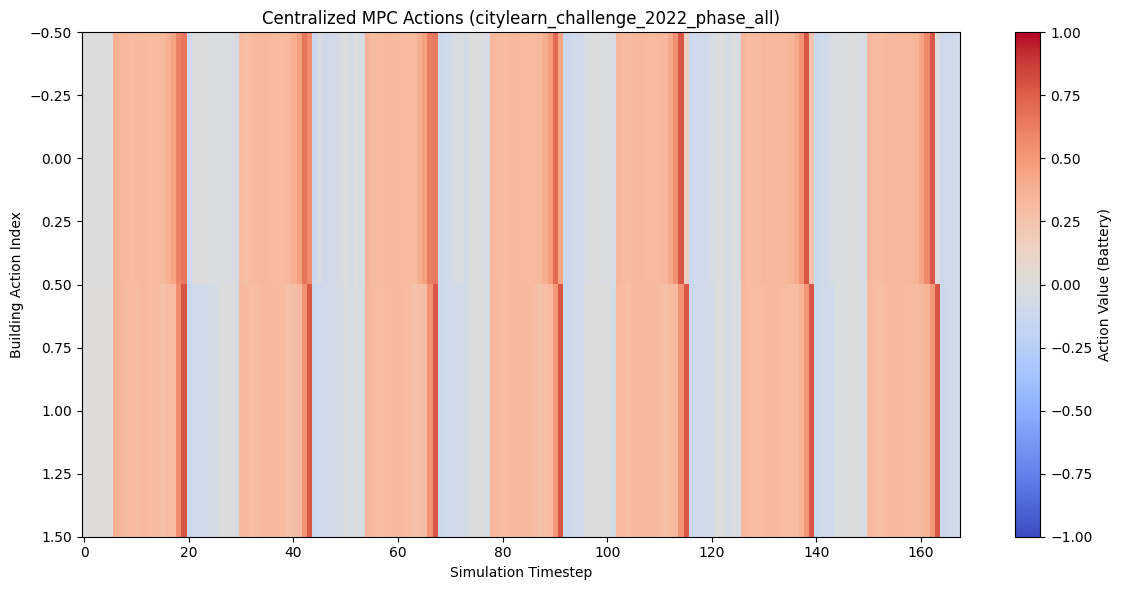

In [9]:
# Plot actions performance
plt.figure(figsize=(12, 6))
# Transpose for plotting: actions on y-axis, time on x-axis
plt.imshow(total_actions_log_np.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Action Value (Battery)')
plt.xlabel('Simulation Timestep')
plt.ylabel('Building Action Index')
plt.title(f'Centralized MPC Actions ({DATASET_NAME})')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'mpc_actions_heatmap.png'))
plt.show() 

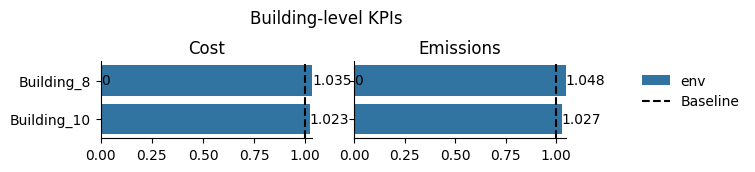

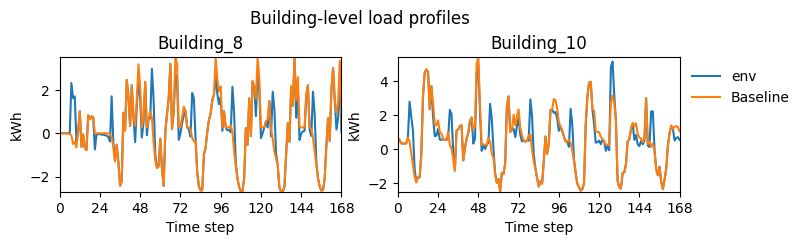

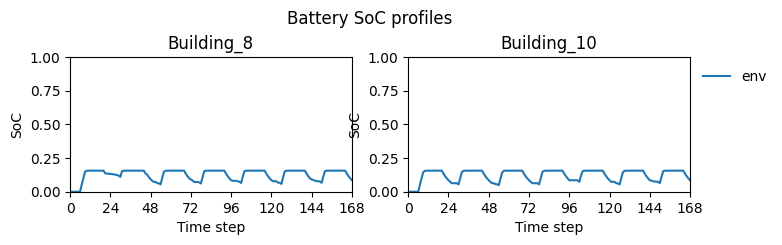

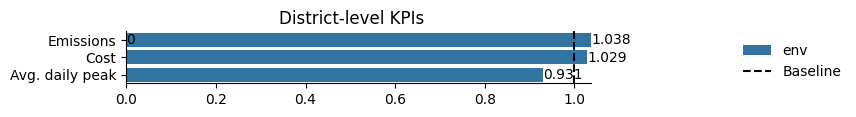

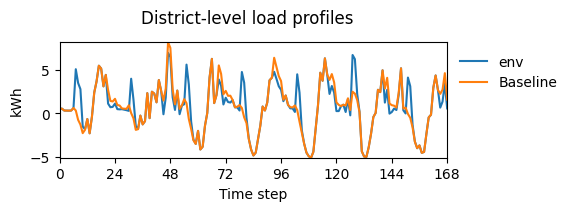

In [10]:
plots = plot_simulation_summary({'env': env}, ret=True)

In [11]:
for plot_name in plots:
    plots[plot_name].savefig(f'{results_dir}/{plot_name}')

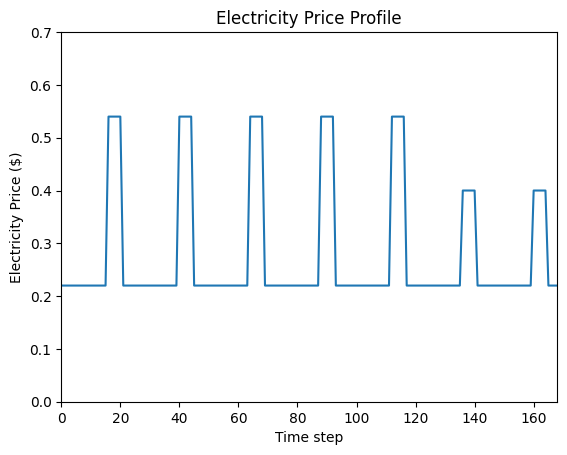

In [12]:
plt.plot(env.buildings[0].pricing.electricity_pricing)
plt.ylim(0,0.7)
plt.ylabel('Electricity Price ($)')
plt.xlabel('Time step')
plt.title('Electricity Price Profile')
plt.savefig(os.path.join(results_dir, 'electricity_price.png'))

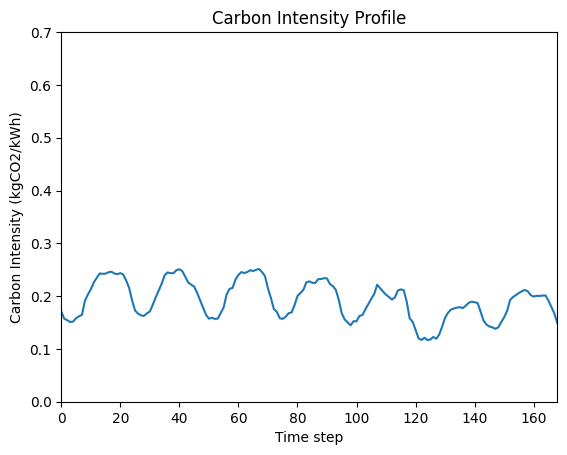

In [13]:
plt.plot(env.buildings[0].carbon_intensity.carbon_intensity)
plt.ylim(0,0.7)
plt.ylabel('Carbon Intensity (kgCO2/kWh)')
plt.xlabel('Time step')
plt.title('Carbon Intensity Profile')
plt.savefig(os.path.join(results_dir, 'carbon_intensity.png'))